<a href="https://colab.research.google.com/github/NoobBeginnerReal/SHB-Stock-Prediction-using-LSTM/blob/main/Copy_of_SHB_Stock_Price_Prediction_using_LSTM_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETTING UP

It is necessary to install the required library for this study that is the vnstock, and it has to be install from the start with every run

In [ ]:
!pip install -U vnstock

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 7.1 MB/s eta 0:00:00


Next will be some essential libraries that will be used in this study for building the forecasting model

In [ ]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import date
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# GETTING THE DATA
The Python code is self explanatory. Declare stock and shb_data objects to
retrieve all daily prices of SHB in 10 years period and save to a csv file for further analysis

In [ ]:
from vnstock import *
import pandas as pd

# Get SHB historical stock prices (default = daily)
stock = Vnstock().stock(symbol='SHB', source='VCI')
shb_data = stock.quote.history(start='2014-01-01', end='2024-12-31')

#Save to a dataframe
df = pd.DataFrame(shb_data)
df.to_csv("SHB_stock_data_2014-2024.csv", index=False, encoding='utf-8')

print("SHB stock data saved")


    Khi tiếp tục sử dụng Vnstock3, bạn xác nhận rằng bạn đã đọc, hiểu và đồng ý với Chính sách quyền riêng tư và Điều khoản, điều kiện về giấy phép sử dụng Vnstock3.

    Chi tiết:

    - Giấy phép sử dụng phần mềm: https://vnstocks.com/docs/tai-lieu/giay-phep-su-dung
    - Chính sách quyền riêng tư: https://vnstocks.com/docs/tai-lieu/chinh-sach-quyen-rieng-tu
    


2025-02-28 04:08:25 - vnstock.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


SHB stock data saved


Explore the data a bit

In [ ]:
print(df.head())
print(df.info())
print(df.shape)
print(df.describe())

        time  open  high   low  close   volume
0 2014-01-02  1.99  1.99  1.97   1.97  1001762
1 2014-01-03  1.97  1.99  1.94   1.97  1101674
2 2014-01-06  1.97  1.99  1.94   1.97  2464187
3 2014-01-07  1.79  2.02  1.79   1.99  3528757
4 2014-01-08  1.99  2.02  1.99   1.99  1438058
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2743 entries, 0 to 2742
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    2743 non-null   datetime64[ns]
 1   open    2743 non-null   float64       
 2   high    2743 non-null   float64       
 3   low     2743 non-null   float64       
 4   close   2743 non-null   float64       
 5   volume  2743 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 128.7 KB
None
(2743, 6)
                                time         open         high          low  \
count                           2743  2743.000000  2743.000000  2743.000000   
mean   2019-07-0

Data Visualization

Text(0, 0.5, 'SHB Price')

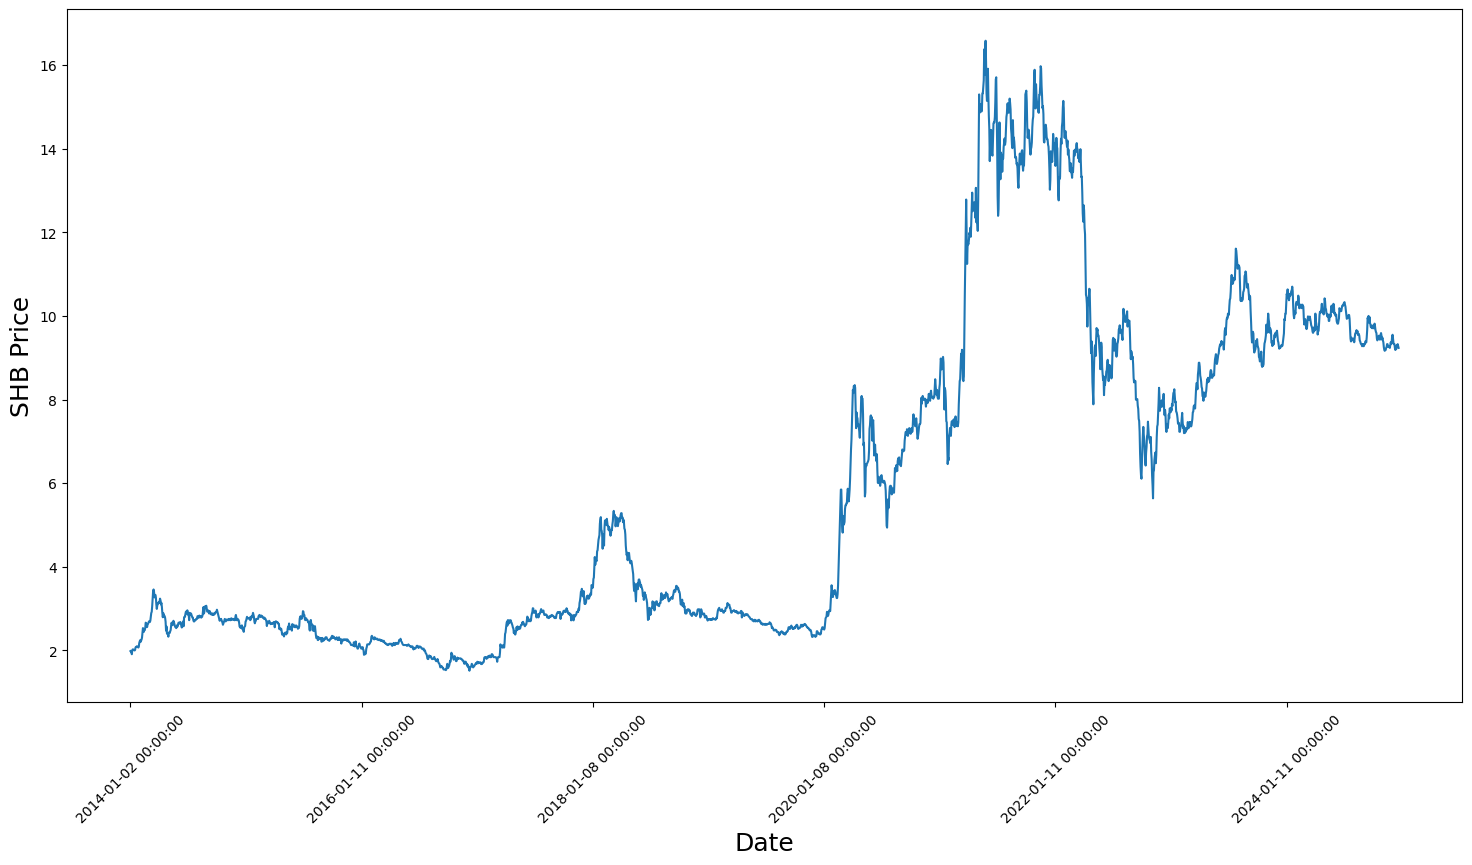

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(range(df.shape[0]), (df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['time'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('SHB Price',fontsize=18)

This graph says a lot about the Bank. Bursting and volatile stock price behavior, very suitable for learning and applying models and give me a chance to test how good the predictions will be for a lot of situations

# PREPROCESSING & SPLITTING & NORMALIZING

Train data shape: (2194, 1)
Test data shape: (549, 1)


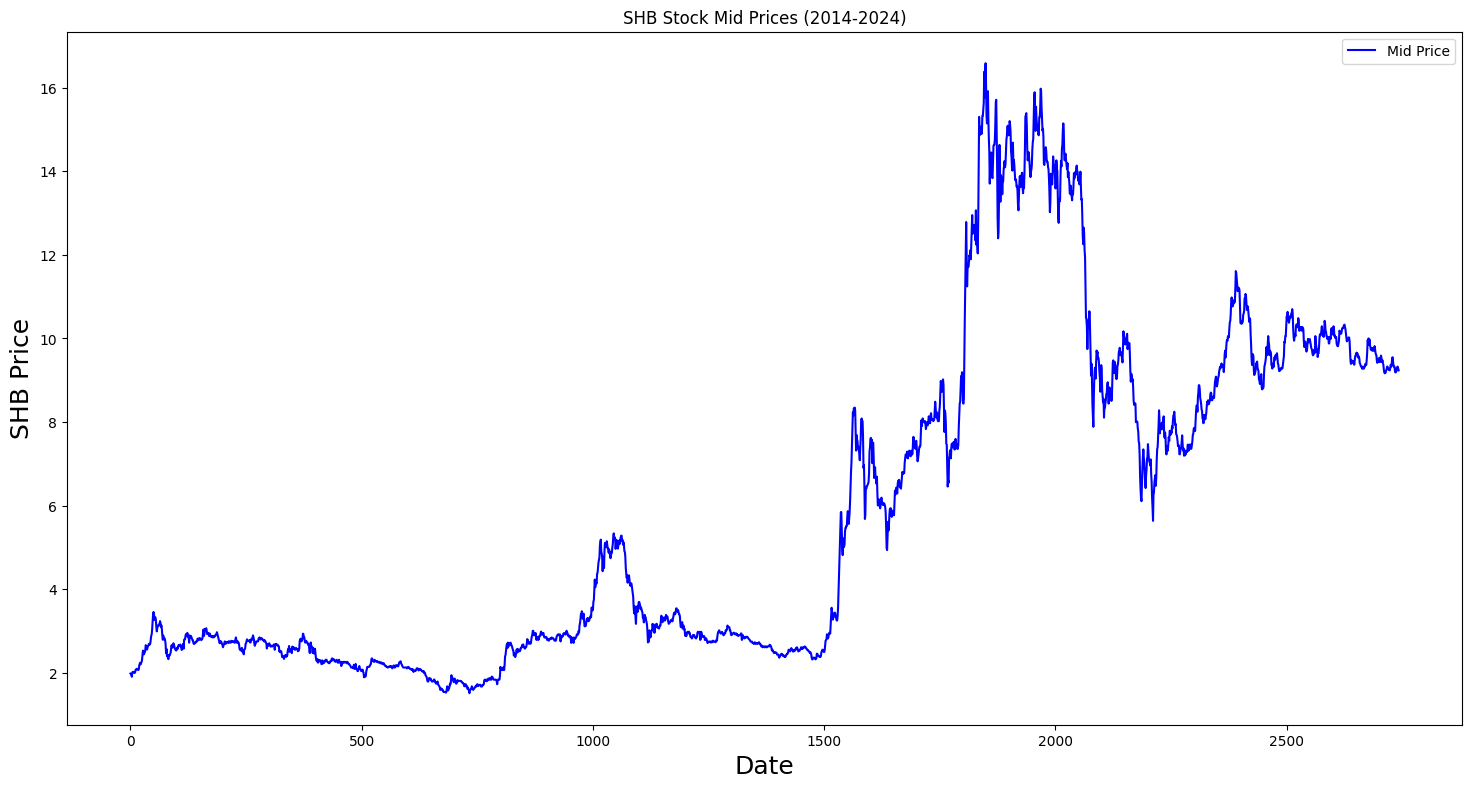

In [ ]:
# Calculate the mid prices from the high and low prices
df['mid_price'] = (df['high'] + df['low']) / 2

# Initialize MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform mid prices
df['mid_price_scaled'] = scaler.fit_transform(df[['mid_price']])

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(df) * 0.8)
train_data = df['mid_price_scaled'][:train_size].values.reshape(-1, 1)
test_data = df['mid_price_scaled'][train_size:].values.reshape(-1, 1)

# Print dataset shapes for verification
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Plot the mid prices
plt.figure(figsize=(18,9))
plt.plot(df.index, df['mid_price'], label="Mid Price", color='blue')
plt.xlabel('Date', fontsize=18)
plt.ylabel('SHB Price', fontsize=18)
plt.title("SHB Stock Mid Prices (2014-2024)")
plt.legend()
plt.show()

In [ ]:
# Define smoothing window size
smoothing_window_size = 500

# Train the scaler and apply smoothing in chunks
for di in range(0, len(train_data), smoothing_window_size):
    end_index = min(di + smoothing_window_size, len(train_data))  # Avoid out-of-bounds indexing
    scaler.fit(train_data[di:end_index])  # Fit scaler to this chunk
    train_data[di:end_index] = scaler.transform(train_data[di:end_index])  # Normalize this chunk

# Normalize any remaining data (last portion if not a multiple of smoothing_window_size)
if len(train_data) % smoothing_window_size != 0:
    remaining_start = (len(train_data) // smoothing_window_size) * smoothing_window_size
    scaler.fit(train_data[remaining_start:])  # Fit scaler to remaining portion
    train_data[remaining_start:] = scaler.transform(train_data[remaining_start:])


In [ ]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)


we now smooth the data using the exponential moving average. This helps eliminate the raggedness of stock prices and produce a smoother curve

In [ ]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(len(train_data)):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)


# 1 STEP AHEAD PREDICTION USING AVERAGING

Standard Moving Average Prediction

Loops through train_data from window_size to N. For each pred_idx, take the last
100 values and compute the mean - the predicted value for train_data[pred_idx]
Calculate the MSE

In [ ]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.index[pred_idx]

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(np.mean(mse_errors)))


MSE error for standard averaging: 0.01847


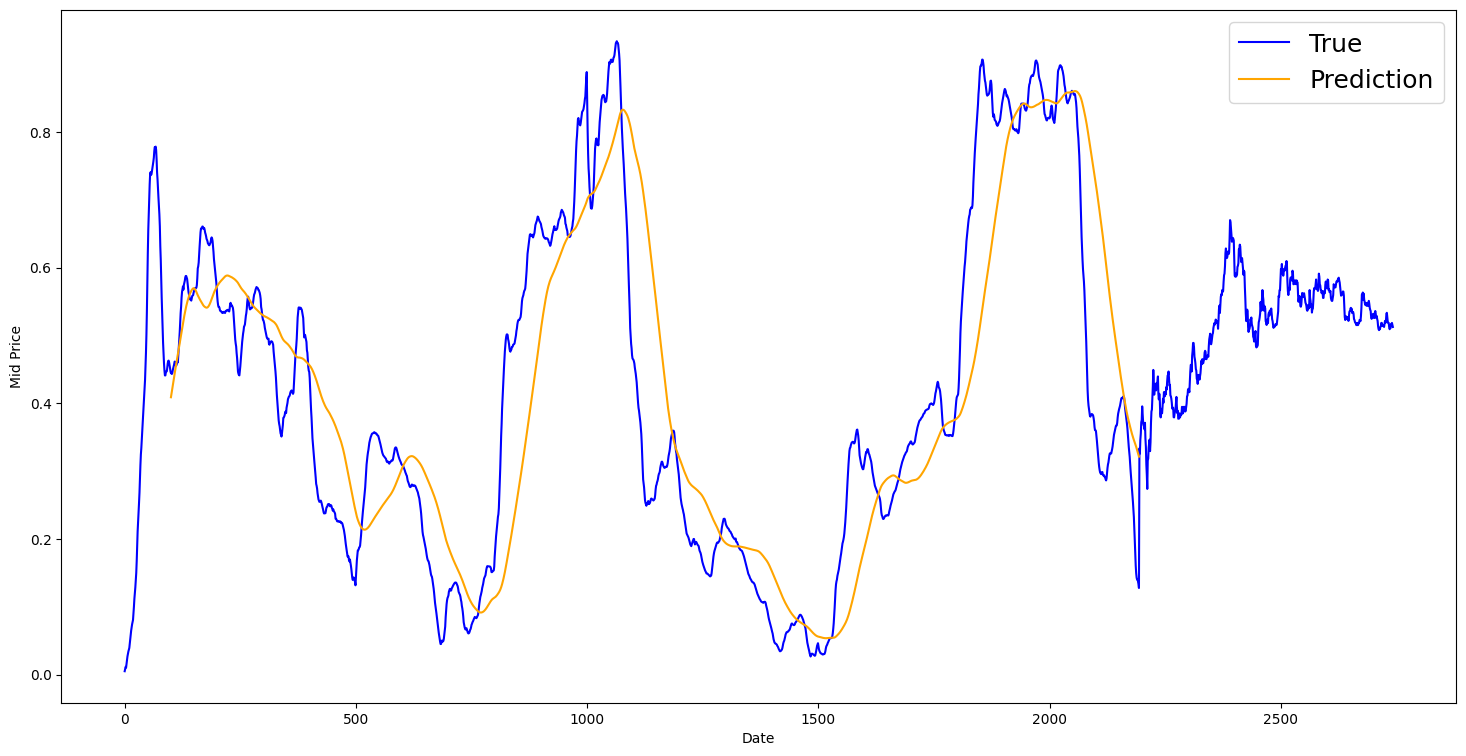

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(np.mean(mse_errors)))


MSE error for EMA averaging: 0.00016


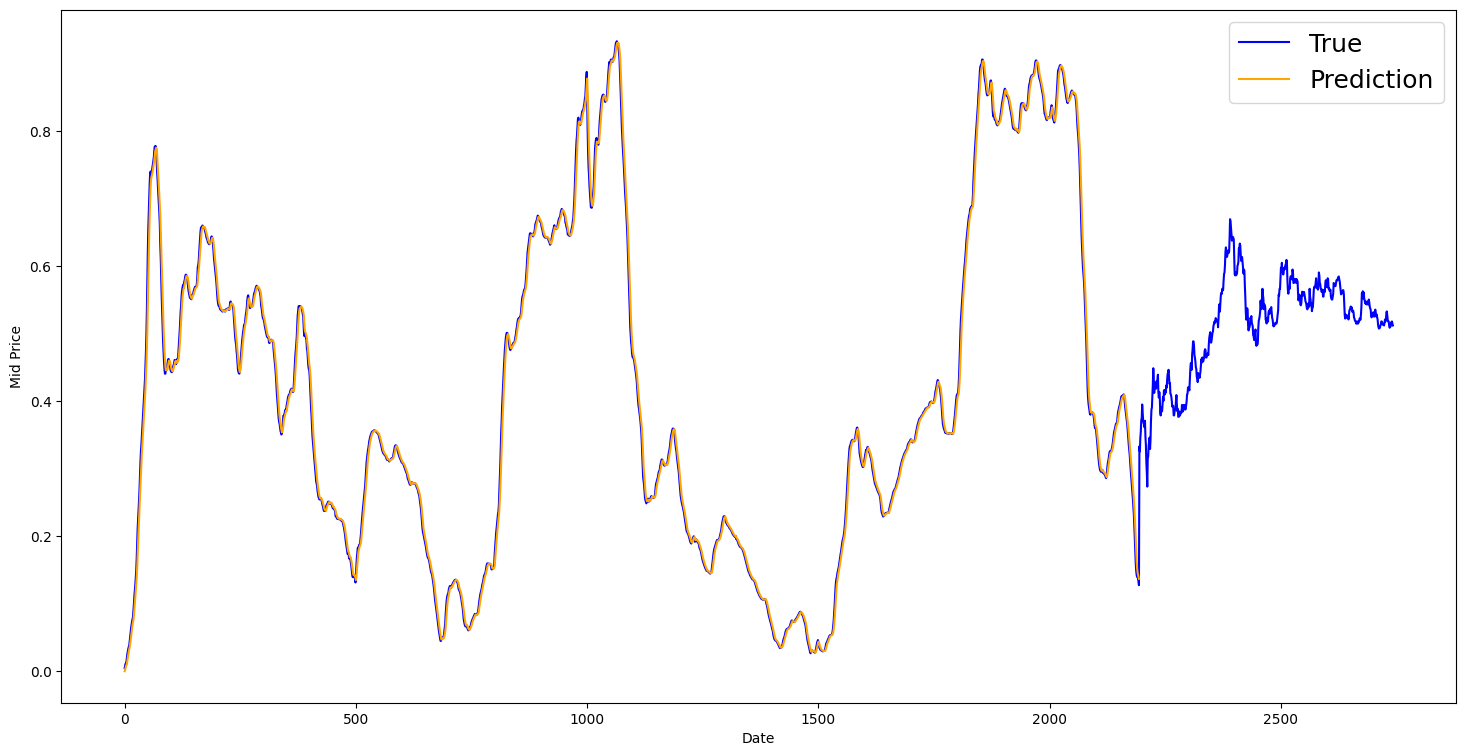

In [ ]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


# LSTM

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("SHB_stock_data_2014-2024.csv")  # Update with your filename
df['time'] = pd.to_datetime(df['time'])  # Convert time to datetime
df.set_index('time', inplace=True)  # Set time as index

# Select closing price for prediction
df['mid_price'] = (df['high'] + df['low']) / 2  # Using mid price
prices = df['mid_price'].values.reshape(-1, 1)

# Scale data
scaler = MinMaxScaler(feature_range=(0,1))
prices_scaled = scaler.fit_transform(prices)

# Create sequences
sequence_length = 200  # Use last 50 days to predict next day
X, y = [], []
for i in range(len(prices_scaled) - sequence_length):
    X.append(prices_scaled[i:i+sequence_length])
    y.append(prices_scaled[i+sequence_length])

X, y = np.array(X), np.array(y)
print(f"Data shape: X={X.shape}, y={y.shape}")  # Check data shape


Data shape: X=(2543, 200, 1), y=(2543, 1)


In [ ]:
# Build the model
model = Sequential()

# First LSTM Layer
model.add(LSTM(200, activation='relu', return_sequences=False, input_shape=(sequence_length, 1)))
model.add(tf.keras.layers.Dropout(0.1))  # Dropout rate 10%

# Second LSTM Layer
# model.add(LSTM(150, activation='tanh', return_sequences=True))  # Keep return_sequences=True
# model.add(tf.keras.layers.Dropout(0.2))  # Dropout rate 20%

# Third LSTM Layer
# model.add(LSTM(200, activation='tanh', return_sequences=False))  # Keep return_sequences=True
# model.add(tf.keras.layers.Dropout(0.3))  # Dropout rate 30%

# Fourth LSTM Layer (Final LSTM) (IF WE WANNA ADD ANOTHER LAYER)
# model.add(LSTM(200, activation='tanh', return_sequences=False))  # Last LSTM should have return_sequences=False
# model.add(tf.keras.layers.Dropout(0.4))  # Dropout rate 40%

# Output Layer
model.add(Dense(1))  # Output layer for prediction

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Show model summary
model.summary()



Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 200)                 │         161,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,801 (632.04 KB)

 Trainable params: 161,801 (632.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Split into training and testing
train_size = int(len(X) * 0.8)  # 80% train, 20% test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train model
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))


Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 264ms/step - loss: 0.0466 - mae: 0.1249 - val_loss: 0.0012 - val_mae: 0.0297
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0015 - mae: 0.0232 - val_loss: 3.7924e-04 - val_mae: 0.0148
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 206ms/step - loss: 0.0013 - mae: 0.0211 - val_loss: 3.9817e-04 - val_mae: 0.0152
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - loss: 0.0012 - mae: 0.0198 - val_loss: 6.1593e-04 - val_mae: 0.0205
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 211ms/step - loss: 0.0013 - mae: 0.0208 - val_loss: 5.0884e-04 - val_mae: 0.0184
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - loss: 0.0011 - mae: 0.0204 - val_loss: 4.6816e-04 - val_mae: 0.0176
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - loss: 9.8511e-04 - mae: 0.0187 - val_loss: 3.6727e-04 - val_mae: 0.0151
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - loss: 9.0878e-04 - mae: 0.0177 - val_loss: 6.5852e-04 - val_mae: 0.0214
Epoch 9/50
6

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


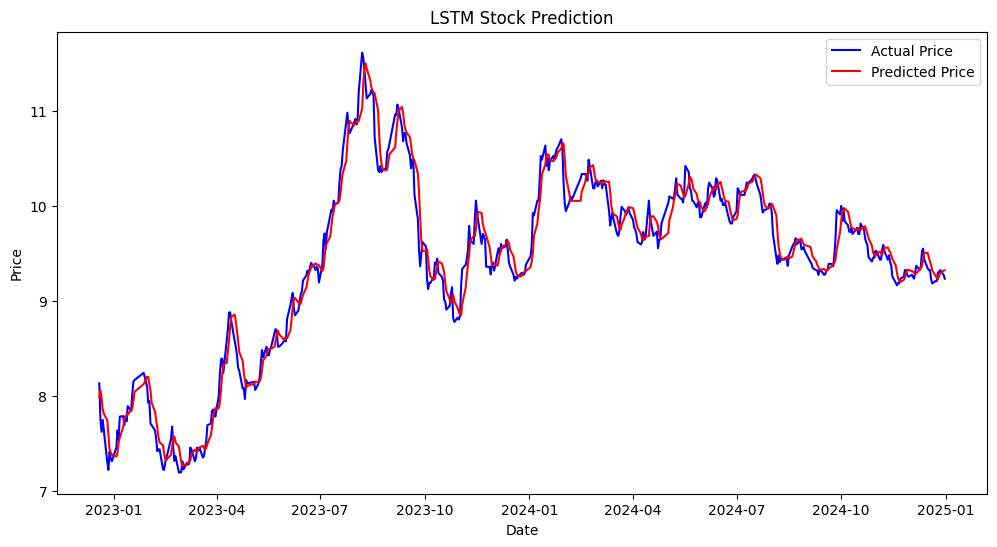

In [ ]:
# Predict on test set
y_pred = model.predict(X_test)

# Convert predictions back to actual scale
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1,1)) # Get the last value of each window
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(df.index[train_size+sequence_length:], y_test_actual, label="Actual Price", color="blue")
plt.plot(df.index[train_size+sequence_length:], y_pred_actual, label="Predicted Price", color="red")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("LSTM Stock Prediction")
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error on test set: ", mae)

avg_price = df['mid_price'].mean()
mae_percentage = (0.009 / avg_price) * 100
print(f"MAE as % of price: {mae_percentage:.2f}%")

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print("Mean absolute percentage error on test set: ", mape)

from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.4f}")


Mean absolute error on test set:  0.008151463284088094
MAE as % of price: 0.15%
Mean absolute percentage error on test set:  1.583271545514138
RMSE: 0.0108


In [ ]:
df['SMA_50'] = df['mid_price'].rolling(window=50).mean()
sma_mae = np.mean(np.abs(df['SMA_50'].dropna() - df['mid_price'][49:]))  # Compute SMA MAE

print(f"LSTM MAE: {0.0014 * 100:.2f}%, SMA MAE: {sma_mae / df['mid_price'].mean() * 100:.2f}%")


LSTM MAE: 0.14%, SMA MAE: 7.89%


# BACKTESTING TRADING ALGO

In [ ]:
y_pred = model.predict(X_test)  # Predict next-day prices
df['Actual Price'] = df['close']  # ✅ Use close price
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1,1))  # Convert predictions back to real prices
df.loc[df.index[train_size + sequence_length:], 'Predicted Price'] = y_pred_actual.flatten()  # ✅ Store LSTM predictions

In [ ]:
print(df.columns)  # Check available columns


In [ ]:
df['Signal'] = np.where(df['Predicted Price'].notnull() &
                        (df['Predicted Price'] < df['Actual Price'].shift(1)), 1, -1)

In [ ]:
initial_capital = 10000  # Start with $10,000
df['Returns'] = df['Signal'].shift(1) * df['Actual Price'].pct_change()  # Apply strategy returns
df['Portfolio Value'] = initial_capital * (1 + df['Returns']).cumprod()  # Compute portfolio growth

# Compare with a Buy & Hold Strategy
df['Buy & Hold'] = initial_capital * (1 + df['Actual Price'].pct_change()).cumprod()

# Plot LSTM Strategy vs. Buy & Hold
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Portfolio Value'], label="LSTM Strategy", color="red")
plt.plot(df.index, df['Buy & Hold'], label="Buy & Hold", color="blue")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("LSTM Trading Strategy vs. Buy & Hold")
plt.show()


In [ ]:
# Calculate final portfolio value
final_lstm = df['Portfolio Value'].iloc[-1]
final_hold = df['Buy & Hold'].iloc[-1]
print(f"Final LSTM Portfolio: ${final_lstm:.2f}")
print(f"Final Buy & Hold Portfolio: ${final_hold:.2f}")

# Calculate Sharpe Ratio (Risk-adjusted return)
returns = df['Returns'].dropna()
sharpe_ratio = returns.mean() / returns.std() * np.sqrt(252)  # 252 trading days per year
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Initial capital
initial_capital = 10000  # Start with $10,000

# Assuming df already contains:
# 'Actual Price' -> The actual stock closing price
# 'Predicted Price' -> The predicted price from LSTM

# Ensure Actual Price is numeric
df['Actual Price'] = pd.to_numeric(df['Actual Price'], errors='coerce')

# Drop missing values (if any)
df.dropna(inplace=True)

# Compute daily percentage change for returns
df['Price Change %'] = df['Actual Price'].pct_change()


In [ ]:
threshold = 0.01  # 1% threshold to enter trades

# Initialize signal as 0 (Hold)
df['Signal_LSTM'] = 0

# Buy if predicted price is at least 1% higher than previous day's actual price
df.loc[df['Predicted Price'] > df['Actual Price'].shift(1) * (1 + threshold), 'Signal_LSTM'] = 1  # Buy signal

# Sell if predicted price is at least 1% lower than previous day's actual price
df.loc[df['Predicted Price'] < df['Actual Price'].shift(1) * (1 - threshold), 'Signal_LSTM'] = -1  # Sell signal

# Compute strategy returns
df['Returns_LSTM'] = df['Signal_LSTM'].shift(1) * df['Price Change %']

# Compute portfolio value over time
df['Portfolio_LSTM'] = initial_capital * (1 + df['Returns_LSTM']).cumprod()


In [ ]:
short_window = 10  # Short MA (e.g., 10 days)
long_window = 50   # Long MA (e.g., 50 days)

# Compute moving averages
df['Short MA'] = df['Actual Price'].rolling(short_window).mean()
df['Long MA'] = df['Actual Price'].rolling(long_window).mean()

# Initialize signal as 0 (Hold)
df['Signal_MA'] = 0

# Buy when Short MA crosses above Long MA
df.loc[df['Short MA'] > df['Long MA'], 'Signal_MA'] = 1  # Buy signal

# Sell when Short MA crosses below Long MA
df.loc[df['Short MA'] < df['Long MA'], 'Signal_MA'] = -1  # Sell signal

# Compute strategy returns
df['Returns_MA'] = df['Signal_MA'].shift(1) * df['Price Change %']

# Compute portfolio value over time
df['Portfolio_MA'] = initial_capital * (1 + df['Returns_MA']).cumprod()


In [ ]:
# Compute buy & hold strategy (just holding the stock)
df['Portfolio_BuyHold'] = initial_capital * (1 + df['Price Change %']).cumprod()


In [ ]:
# Plot LSTM Strategy Performance
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Portfolio_LSTM'], label="LSTM Strategy", color="red")
plt.plot(df.index, df['Portfolio_BuyHold'], label="Buy & Hold", color="blue", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("Threshold-Based LSTM Trading vs. Buy & Hold")
plt.legend()
plt.show()


In [ ]:
# Plot Moving Average Strategy Performance
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Portfolio_MA'], label="Moving Average Crossover", color="green")
plt.plot(df.index, df['Portfolio_BuyHold'], label="Buy & Hold", color="blue", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("Moving Average Crossover vs. Buy & Hold")
plt.legend()
plt.show()


In [ ]:
# Plot all strategies together
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Portfolio_LSTM'], label="LSTM Strategy", color="red")
plt.plot(df.index, df['Portfolio_MA'], label="Moving Average Crossover", color="green")
plt.plot(df.index, df['Portfolio_BuyHold'], label="Buy & Hold", color="blue", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.title("Trading Strategies Comparison")
plt.legend()
plt.show()
